# Multiple linear regression: Advanced regression analysis I

In this notebook, we will delve deeper into multiple linear regression. We employ statistical tests and diagnostics from the Statsmodels library to assess model quality comprehensively. Using the MTCars dataset, we explore linearity and multicollinearity, as well as fit a model, enriching our regression analysis toolkit.

## The dataset - `mtcars`

This notebook makes use of the MTCars datasetd. We begin by importing some libraries, which will help us load and explore our data. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load the data 
df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/regression_sprint/mtcars.csv', index_col=0)
df.head(10)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
model,,,,,,,,,,,
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2


In [3]:
#Explore the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,32.0,20.090625,6.026948,10.400,15.42500,19.200,22.80,33.900
cyl,32.0,6.187500,1.785922,4.000,4.00000,6.000,8.00,8.000
disp,32.0,230.721875,123.938694,71.100,120.82500,196.300,326.00,472.000
hp,32.0,146.687500,68.562868,52.000,96.50000,123.000,180.00,335.000
drat,32.0,3.596563,0.534679,2.760,3.08000,3.695,3.92,4.930
wt,32.0,3.217250,0.978457,1.513,2.58125,3.325,3.61,5.424
qsec,32.0,17.848750,1.786943,14.500,16.89250,17.710,18.90,22.900
vs,32.0,0.437500,0.504016,0.000,0.00000,0.000,1.00,1.000
am,32.0,0.406250,0.498991,0.000,0.00000,0.000,1.00,1.000
gear,32.0,3.687500,0.737804,3.000,3.00000,4.000,4.00,5.000


It appears both `vs` and `am` are categorical variables. From the dataset description [available here](https://rpubs.com/neros/61800), `vs` takes on a value of 0/1 depending on whether the engine layout is a *V* or *straight*, and `am` takes on a 0/1 value depending on whether the transmission is *automatic* or *manual*, both respectively.

Note that they don't need to be one-hot encoded because they are binary categorical variables (only two categories each), and they already make use of zeros and ones.

## Checking for linearity

The first thing we need to check is the mathematical relationship between each predictor variable and the response variable. What we are looking for here is known as linearity. A linear relationship means that a change in the response *Y* due to a one-unit change in the predictor $X_j$ is constant, regardless of the value of $X_j$.

If we fit a regression model to a non-linear dataset, it will fail to adequately capture the relationship in the data - resulting in a mathematically inappropriate model. To check for linearity, we can produce scatter plots of each predictor against the response variable. The intuition here is that we are looking for obvious linear relationships.

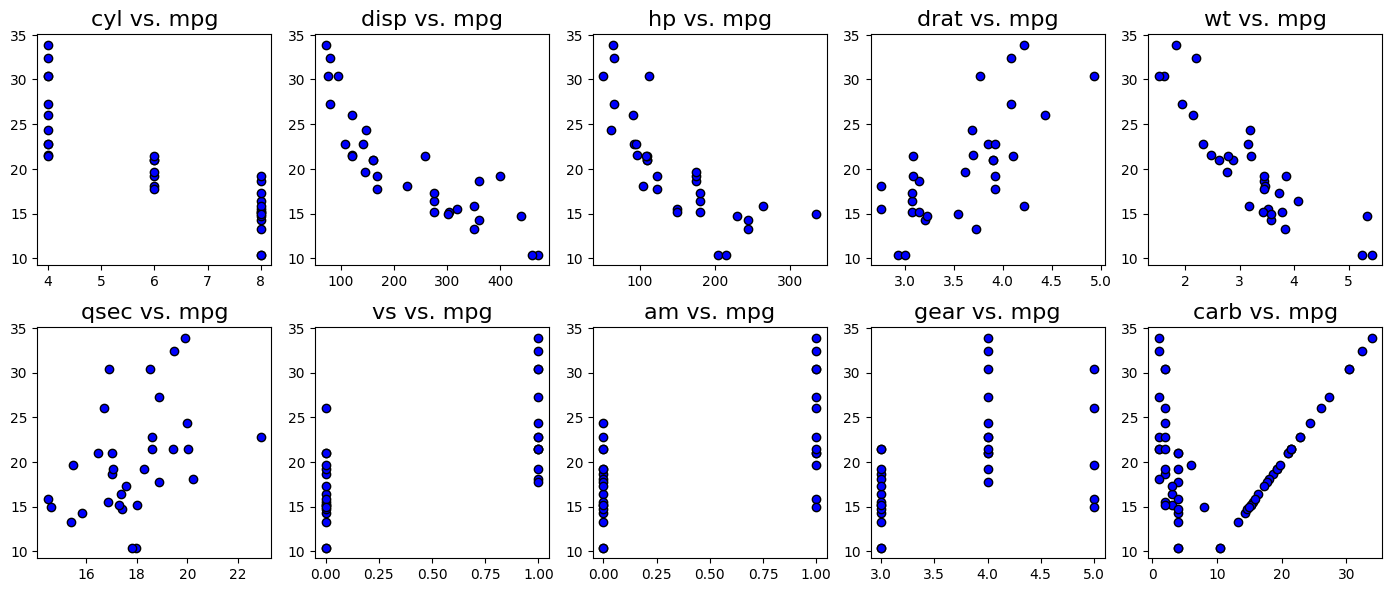

In [4]:
fig, axs = plt.subplots(2,5, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()

for index, column in enumerate(df.columns):
    axs[index-1].set_title("{} vs. mpg".format(column),fontsize=16)
    axs[index-1].scatter(x=df[column],y=df['mpg'],color='blue',edgecolor='k')
    
fig.tight_layout(pad=1)

It appears at least half of the variables, including all five on the top row, have an approximately linear relationship. Here, a trend between each of `cyl, disp, hp, drat, wt`, `qsec` and `mpg` seems to exist. However, `carb` and `gear` exhibit no linearity with `mpg`.

Based on these observations, it appears there is sufficient linearity present to proceed with applying a linear regression model. Let's continue.

We'll create a copy of the dataset so that we can play with it and process it using `statsmodels.OLS()`, which is the least squares regression module within the `statsmodels` library. We'll be carrying out our regression with this module.

In [5]:
df1 = df.copy()

## Checking for multicollinearity

Multicollinearity refers to the presence of a strong correlation among two or more of the predictor variables in the dataset. The presence of any correlation among predictors is detrimental to model quality for two reasons:

- It tends to increase the standard error;

- It becomes difficult to estimate the effect of any one predictor variable on the response variable.

We will check for multicollinearity by generating pairwise scatter plots among predictors and further generating a correlation heatmap.

### Pairwise scatter plots

As can be inferred by the name, a pairwise scatter plot simply produces a visual $n \times n$ matrix, where $n$ is the total number of variables compared, in which each cell represents the relationship between two variables. The diagonal cells of this visual represent the comparison of a variable with itself, and as such, they are substituted by a representation of the distribution of values taken by the visual.

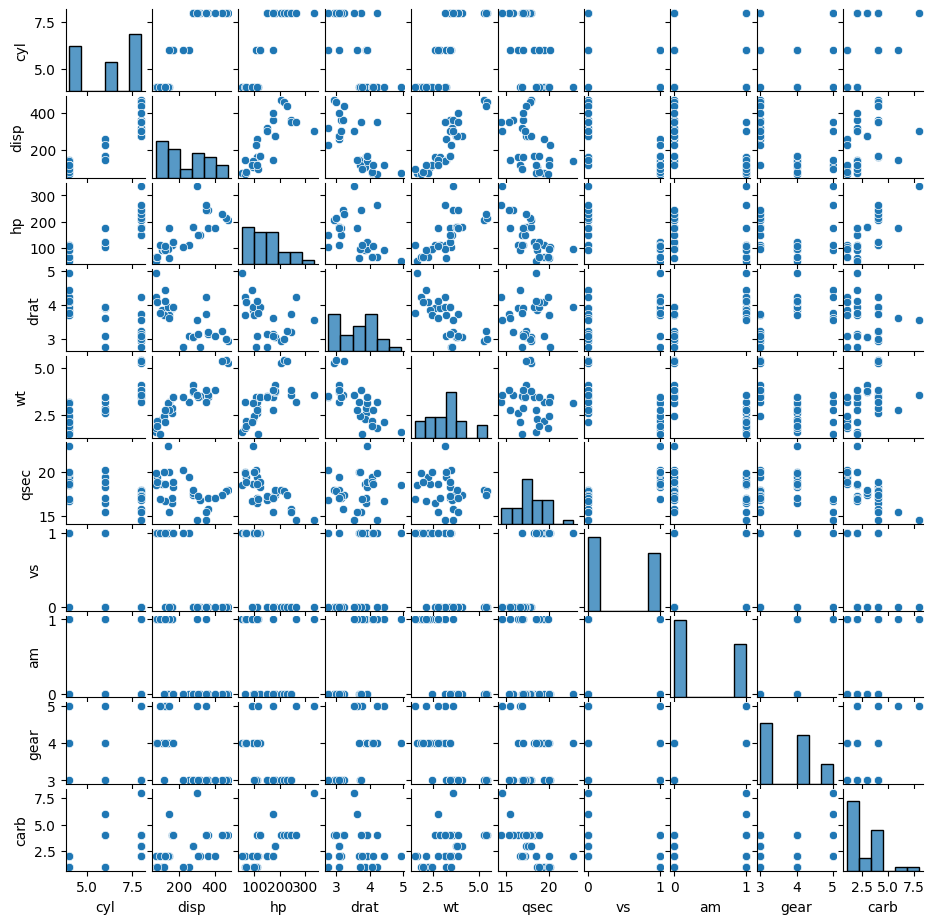

In [6]:
# Due to the number of visuals created, this codeblock takes about one minute to run.
from seaborn import pairplot
g = pairplot(df1.drop('mpg', axis='columns'))
g.fig.set_size_inches(9,9)

### Correlation heatmap

Another way we can visually discover linearity between two or more variables within our dataset is through the use of a correlation heatmap. Similar to the pairwise scatter plot we produced above, this visual presents a matrix in which each row represents a distinct variable, with each column representing the correlation between this variable and another one within the dataset.    

In [7]:
# We only compare the predictor variables, and thus drop the target `mpg` column.
corr = df1.drop('mpg', axis='columns').corr()

In [9]:
from statsmodels.graphics.correlation import plot_corr

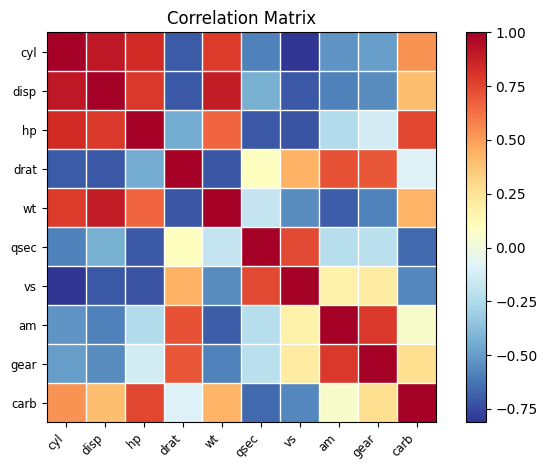

In [10]:
fig=plot_corr(corr,xnames=corr.columns)

From both the pairwise scatterplot and correlation heatmap, we can see several strong correlations among predictors:

- `disp` and `cyl`;
- `cyl` and `hp`;
- `hp` and `carb`;
- `cyl` and `vs`;
- `cyl` and `wt`.

Let's keep these in mind when we build and continue to check the quality of our model.

## Fitting the model using `statsmodels.OLS`

`sklearn` is limited in terms of the metrics and tools available to evaluate the appropriateness of the regression models we fit. Thus, as a means to expand our analysis, we import the `statsmodels` library, which has a rich set of statistical tools that we can use. 

In [11]:
import statsmodels.formula.api as sm

### Generating the regression string

Those who are familiar with the R language will know that fitting a machine learning model requires a kind of string of the form:

`y ~ X`

which is read as follows: "Regress y on X". The `statsmodels` library works similarly, so we need to generate an appropriate string to feed to the method when we wish to fit the model.

In [12]:
formula_str = df1.columns[0]+' ~ '+'+'.join(df1.columns[1:]); formula_str

'mpg ~ cyl+disp+hp+drat+wt+qsec+vs+am+gear+carb'

In other words, we will regress `mpg` on all of the predictors.

### Construct and fit the model

We now go ahead and fit our model. We use the `ols` or Ordinary Least Squares regression model from the `statsmodels` library to do this:  

In [13]:
model=sm.ols(formula=formula_str, data=df1)

In [14]:
fitted = model.fit()

### Print model summary

Unlike the `sklearn` models we've seen so far which only produce a couple of statistics following the fitting process, our new model produces a rich set of statistics to help us analyse its appropriateness.   

In [15]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     13.93
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           3.79e-07
Time:                        16:04:36   Log-Likelihood:                -69.855
No. Observations:                  32   AIC:                             161.7
Df Residuals:                      21   BIC:                             177.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3034     18.718      0.657      0.5

The above result provides the summary output of the multiple linear regression model fitted to the data.

On the top of the summary report, we'll find the **Model information section**, which provides details about the type of model utilised and the estimation method employed. Following this, the **Model fit** section offers crucial metrics such as R-squared and adjusted R-squared, providing insights into how well the model fits the data. Additionally, the F-statistic, accompanied by its associated p-value, evaluates the overall significance of the model. Moving further down, the **Coefficients table** displays estimates, standard errors, t-values, and p-values for each predictor variable, elucidating their individual significance and impact on the dependent variable. Lastly, we'll encounter additional diagnostics, encompassing various diagnostic tests aimed at assessing the model's assumptions and identifying potential issues like multicollinearity or non-normality of residuals. This succinct summary encapsulates the most salient components of a stats model summary report, offering a comprehensive overview of the model's performance and reliability.



# Multiple linear regression: Advanced regression analysis II

This notebook then proceeds into assessing the quality of a regression model by examining residuals for independence, homoscedasticity, normality, and outliers. We'll visualise residuals against predictor variables and fitted values and inspect histograms and Q-Q plots to ensure normality. Furthermore, we'll utilise Cook's distance to identify influential outliers.


In [3]:
import ssl

# Set the path to the CA certificates bundle
ssl._create_default_https_context = ssl._create_unverified_context


Let's create a copy of the dataset so that we can play with and process it using `statsmodels.OLS()`.

In [6]:
df1 = df.copy()

## Fitting the model using `statsmodels.OLS`

As was previously motivated, `sklearn` is limited in terms of the metrics and tools available to evaluate the appropriateness of the regression models we fit. Thus, to further expand our analysis, we import the `statsmodels` library, generate the regression string, fit the model using `ols` and finally print the model summary.

In [7]:
import statsmodels.formula.api as sm

In [10]:
#Generate the regression string
formula_str = df1.columns[0]+' ~ '+'+'.join(df1.columns[1:]); formula_str

'mpg ~ cyl+disp+hp+drat+wt+qsec+vs+am+gear+carb'

In [11]:
#Construct and fit the model using ols
model=sm.ols(formula=formula_str, data=df1)
fitted = model.fit()

In [12]:
#Print the model summary
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     13.93
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           3.79e-07
Time:                        17:07:28   Log-Likelihood:                -69.855
No. Observations:                  32   AIC:                             161.7
Df Residuals:                      21   BIC:                             177.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3034     18.718      0.657      0.5

## Checking for independence

We have done checks for linearity and multicollinearity, which both refer to the predictor variables. Now we'll move on to checking some of the artefacts of the fitted model for three more statistical phenomena, which will further help us determine its quality.

### Residuals vs. predictor variable plots 

The first check we do involves plotting the residuals (vertical distances between each data point and the regression hyperplane). We are looking to confirm the independence assumption here, i.e., the residuals should be independent. If they are, we will see:

- Residuals approximately uniformly randomly distributed about the zero x-axes;

- Residuals not forming specific clusters.

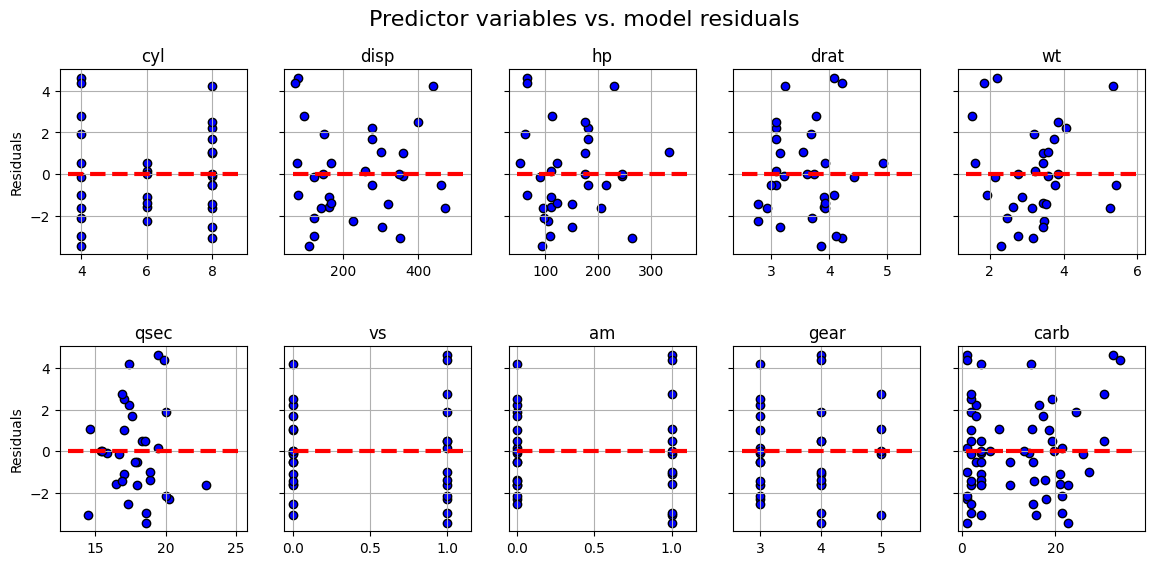

In [13]:
fig, axs = plt.subplots(2,5, figsize=(14,6),sharey=True)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
fig.suptitle('Predictor variables vs. model residuals', fontsize=16)
axs = axs.ravel()

for index, column in enumerate(df.columns):
    axs[index-1].set_title("{}".format(column),fontsize=12)
    axs[index-1].scatter(x=df[column],y=fitted.resid,color='blue',edgecolor='k')
    axs[index-1].grid(True)
    xmin = min(df[column])
    xmax = max(df[column])
    axs[index-1].hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    if index == 1 or index == 6:
        axs[index-1].set_ylabel('Residuals')

Observing the plots above, two things are relatively clear:

- All of the residuals are slightly skewed to the positive (reaching +5 to the positive but only up to about -3 to the negative);

- There is no obvious clustering, except for `cyl` which may present a cluster on the value 6.

Our conclusion here is that the residuals are largely independent.

## Checking for homoscedasticity

The next check we'll do is for whether the variance of the residuals (the error terms) is constant as the fitted values increase. 

### Fitted vs. residuals

We can determine this by plotting the magnitude of the fitted values (i.e.: `mpg`) against the residuals. What we are looking for are the plotted points that approximately form a rectangle. In other words, the magnitude of the residuals should not increase as the fitted values increase (if that is the case, the data will form the shape of a cone on its side).

If the variance is constant, we have observed **_homoscedasticity_**. If the variance is not constant, we have observed **_heteroscedasticity_**. We can use the same plot to check for outliers, which are any plotted points that are visibly separate from the random pattern of the rest of the residuals.

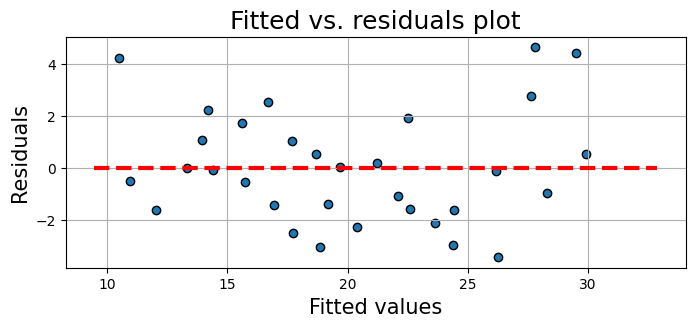

In [13]:
plt.figure(figsize=(8,3))
p=plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin = min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

It appears the points towards the right-hand side of the plot tend to be scattered slightly less densely, indicating the presence of heteroscedasticity. This violates our assumption of homoscedasticity. The presence of these outliers means that those values are weighted too heavily in the prediction process, disproportionately influencing the model's performance. This in turn can lead to the confidence interval for  out-of-sample predictions (unseen data) being unrealistically wide or narrow.

## Checking for normality

Here we attempt to confirm our assumption of normality amongst the residuals. If the residuals are non-normally distributed, confidence intervals can become too wide or too narrow, which leads to difficulty in estimating coefficients based on the minimisation of ordinary least squares.

We can check for violations of the normality assumption in two different ways:

1. Plotting a histogram of the normalised residuals;

2. Generating a Q-Q plot of the residuals.

### Histogram of normalised residuals

We plot a histogram of the residuals to take a look at their distribution. It is fairly easy to pick up when a distribution looks similar to the classic **_bell curve_** shape of the normal distribution.

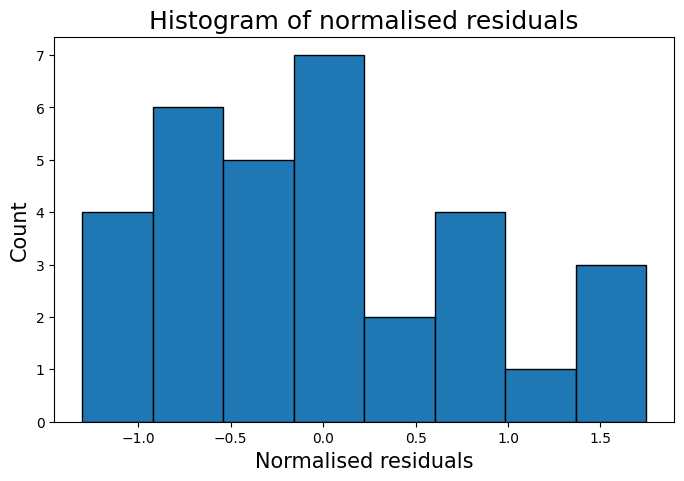

In [14]:
plt.figure(figsize=(8,5))
plt.hist(fitted.resid_pearson,bins=8,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalised residuals',fontsize=15)
plt.title("Histogram of normalised residuals",fontsize=18)
plt.show()

### Q-Q plot of the residuals

A Q-Q plot, also known as a quantile-quantile plot, attempts to plot the theoretical quantiles of the standard normal distribution against the quantiles of the residuals. The one-to-one line, indicated in red below, is the ideal line, indicating normality. The closer the plotted points are to the red line, the closer the residual distribution is to the standard normal distribution.

In [15]:
# We once again use the statsmodel library to assist us in producing our qqplot visualisation. 
from statsmodels.graphics.gofplots import qqplot

<Figure size 800x500 with 0 Axes>

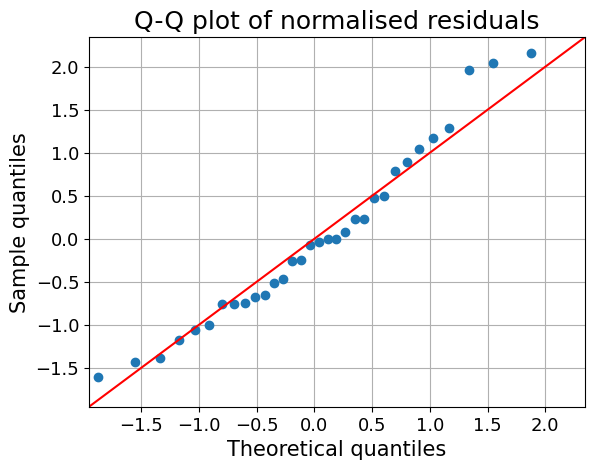

In [16]:
plt.figure(figsize=(8,5))
fig=qqplot(fitted.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalised residuals",fontsize=18)
plt.grid(True)
plt.show()

Judging only from the two checks above, the residuals do appear to be normally distributed.

## Checking for outliers in residuals

The last check we'll make is for outliers amongst the residuals.

### Plotting Cook's Distance

Cook's distance is a calculation thar measures the effect of deleting an observation from the data. Observations with large Cook's distances should be earmarked for closer examination in the analysis due to their disproportionate impact on the model.

In [17]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence

In [18]:
inf=influence(fitted)

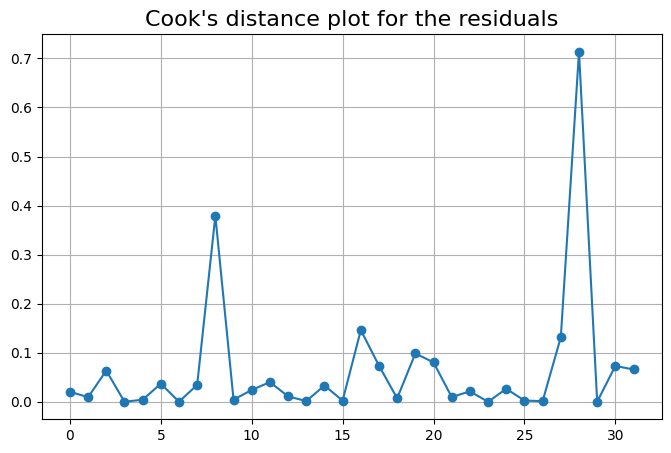

In [19]:
(c, p) = inf.cooks_distance
plt.figure(figsize=(8, 5))
plt.title("Cook's distance plot for the residuals", fontsize=16)
plt.plot(np.arange(len(c)), c, marker='o', linestyle='-')
plt.grid(True)
plt.show()

There are at least two values with much higher Cook's distances than the rest. A rule of thumb for determining whether a Cook's distance is too large is whether it significantly exceeds 1 or is greater than or equal to the value of 4 divided by the number of observations in the dataset.

It does appear that observations 8 and 28 are highly influential in this dataset, and may warrant closer examination.

## Summary

This notebook evaluated the quality of a regression model through a thorough analysis of its residuals. We meticulously examined four key statistical phenomena: **independence**, **homoscedasticity**, **normality**, and **outliers**. Employing visualisations such as **scatter plots** of residuals against predictor variables, **histograms**, and **Q-Q plots**, we scrutinised the adherence of the residuals to these fundamental assumptions. Additionally, we utilised **Cook's distance** to pinpoint influential outliers in the dataset. By the end of this exploration, we gained insights into **interpreting residuals**, **identifying patterns**, and **diagnosing potential issues** in regression models. Armed with this knowledge, we've equipped ourselves with a robust set of tools to ensure the reliability and accuracy of our regression analyses.